# Tutorial for the new data normalisation

In [1]:
import processing as pr

In [2]:
import os
import logging
import importlib

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import extra_data as ed
import extra_geom as eg

import toolbox_scs as tb
import toolbox_scs.detectors as tbdet

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)

In [4]:
xr.set_options(display_style='text')

In [5]:
proposal = 2530
dark_run = 49
run = 50

## Step 1

In the first step we create averaged dark images and corrected images. The calculations are done with Bash scripts. It is called as:

    ./process_run.sh <run> <darkrun>

### create dark images from the dark run for all modules

To process dark run `49` we use 

    ./process_run.sh 49 0
    
The second argument `<darkrun> = 0` tells the script that `<run>=49` is a dark run.

### create normalised images for all modules

To process run `50` we use

    ./process_run.sh 50 49
    
Now we want an "image" run and specify a valid `<darkrun>=49`.

---

The normalisation is done per module and averaging is only done over trains. The individual pulses are kept separatly.

For runs
- Ri is a run with actual images (X-ray pulses) with the sequence (Ri_image, Ri_intradark, Ri_image, ...)
- Rd is a dark run with sequence (Rd_dark, Rd_intradark, Rd_dark, ...)

we now have pulse-resolved images with the data normalised as:

    average_over_trains( {Ri_image - average_over_trains(Ri_indradark) - [average_over_trains(Rd_dark) - average_over_trains(Rd_intradark)]} / XGM )

Only trains with valid XGM data are used.

## Step 2: load the data into one array
After calculating normalised images for all modules we need to group the individual files into one xarray. 

In [6]:
pulse_images = pr.concat_module_images(dirname='processed_runs_xgm', run=50)

If we do not have any XGM data we can use 
    
    ./process_run.sh <run> 0

also for the image run. Then we have to calculate the averages manually.

In [7]:
pulse_images = pr.concat_module_images(dirname='processed_runs_xgm', run=50, run_type='std', image_type='image_average')

pulse_dark = pr.concat_module_images(dirname='processed_runs_xgm', run=50, run_type='std', image_type='dark_average')

In [8]:
dark_images = pr.concat_module_images(dirname='processed_runs_xgm', run=49, run_type='std', image_type='image_average')

dark_dark = pr.concat_module_images(dirname='processed_runs_xgm', run=49, run_type='std', image_type='dark_average')

The data is still pulse-resolved:

In [9]:
pulse_images.shape

(99, 16, 128, 512)

To get one image we average over all pulses:

In [10]:
image = np.mean(pulse_images - pulse_dark - (dark_images - dark_dark), axis=0)

In [11]:
#image = pulse_images.mean(axis=0)

In [12]:
image.shape

(16, 128, 512)

Now the analysis can be continued as done previously.

`image` obtained in the previous cells equals `images` in ``shared/tutorial_analysis.ipynb`` from where the rest of this notebook is taken.
## Step 4: start with the actal analysis
#### copied from ``shared/tutorial_analysis.ipynb``

In [13]:
#quad_pos = [(-124.100, 3.112),  # TR
#            (-133.068, -110.604),  # BR
#            (0.988, -125.236),  # BL
#            (4.528, -4.912)  # TL
#            ]
#

quad_pos = [(-123.0 , 1.72),  # TR
            (-130.0, -110.18),  # BR
            (1.4, -122.78),  # BL
            (2.2, -4.08)  # TL
            ]

geopath = '/gpfs/exfel/sw/software/git/EXtra-geom/' \
                  'docs/dssc_geo_june19.h5'
geom = eg.DSSC_1MGeometry.from_h5_file_and_quad_positions(geopath, quad_pos)

#geom = tbdet.load_geom()
#geom.inspect()

In [14]:
#Some ASICS (squares) are broken and can be manually masked away if desired

masklist = [
    (4, 1, 0),
    (13, 0, 0),
    (1, 0, 6),
]
dssc_mask = tbdet.quickmask_DSSC_ASIC(geom, masklist)

In [15]:
#Assemble the modules to one image. This has not yet been corrected hexagonal to carthesian
preview_image, center = geom.position_modules_fast(image)


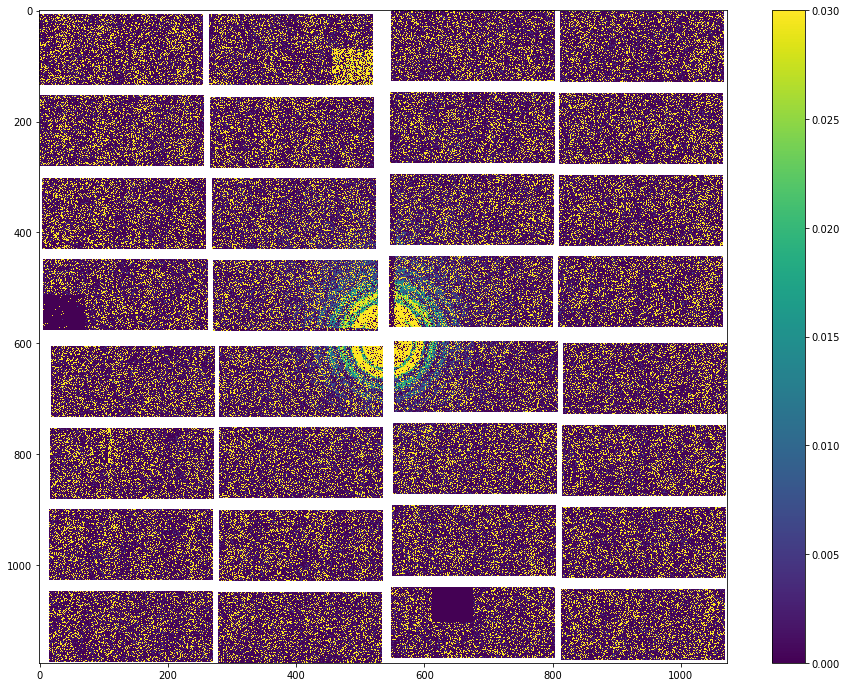

In [16]:
plt.imshow(preview_image, vmin=-0, vmax=0.03, aspect=204.0/236.0)
plt.colorbar()